In [1]:
import pandas as pd
import numpy as np
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

In [2]:

try:
    sleep_page_data = pd.read_csv("extrait_wSleepPage01.csv", delimiter=";")
    print("\n\nSleep Page Data:")
    print(sleep_page_data.head())
    print("\nInfo:")
    print(sleep_page_data.info())
    print("\nSummary Statistics:")
    print(sleep_page_data.describe())

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
    with open("extrait_wSleepPage01.csv", "r") as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if i in range(2, 5): 
                print(f"Line {i + 1}: {line.strip()}")




Sleep Page Data:
         Date  HH  MM      SS    EOG Left   EEG C3-A1     EEG O1-A1  \
0  08/03/2016   1  27      22     0,78125  5,56640625  -12,40234375   
1  08/03/2016   1  27  22,005    1,953125  4,78515625  -11,23046875   
2  08/03/2016   1  27   22,01   -1,67E-14    4,296875  -11,23046875   
3  08/03/2016   1  27  22,015     0,78125  4,78515625  -12,01171875   
4  08/03/2016   1  27   22,02  0,29296875   4,1015625  -13,18359375   

     EEG C4-A1    EEG O2-A1  
0    0,9765625  13,76953125  
1  -0,09765625  17,08984375  
2    0,9765625     17,96875  
3   6,34765625   20,1171875  
4   8,10546875   17,3828125  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248440 entries, 0 to 248439
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Date       248440 non-null  object
 1   HH         248440 non-null  int64 
 2   MM         248440 non-null  int64 
 3   SS         248440 non-null  object
 4   EOG Left   2

In [3]:

eeg_columns = ['EEG C3-A1', 'EEG O1-A1', 'EEG C4-A1', 'EEG O2-A1']
sleep_page_data[eeg_columns] = sleep_page_data[eeg_columns].replace(',', '.', regex=True).astype(float)
ch_names = ['EEG C3-A1', 'EEG O1-A1', 'EEG C4-A1', 'EEG O2-A1']
info = mne.create_info(ch_names=ch_names, sfreq=100, ch_types='eeg')
locations = sleep_page_data[eeg_columns]
locations = locations / 1000.0

In [4]:

for i, ch_name in enumerate(ch_names):
    info['chs'][i]['loc'][:3] = locations[ch_name].values[:3].reshape(1, -1) / 1000.0

raw = mne.io.RawArray(sleep_page_data[eeg_columns].values.T.astype(float), info)

Creating RawArray with float64 data, n_channels=4, n_times=248440
    Range : 0 ... 248439 =      0.000 ...  2484.390 secs
Ready.


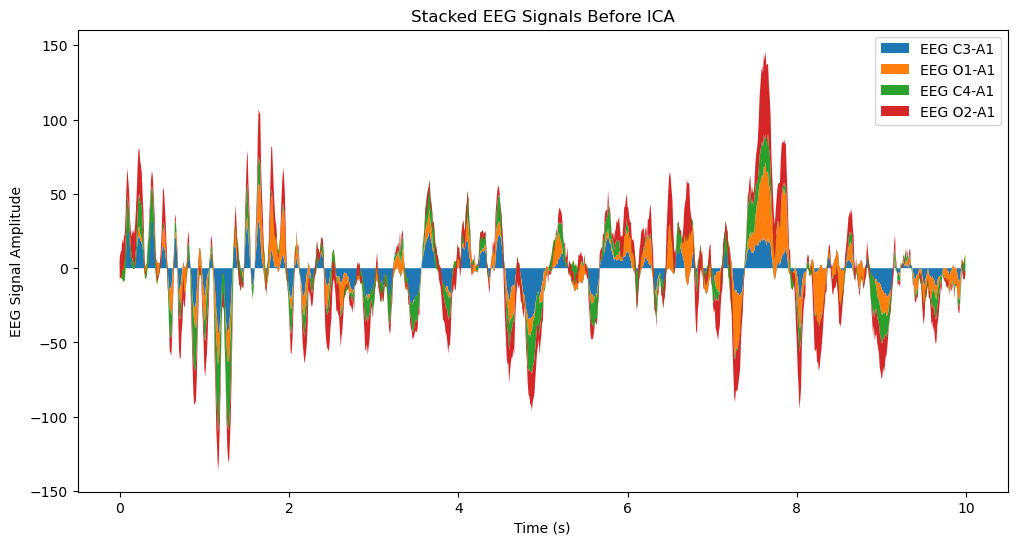

In [5]:

start_time = 0
end_time = 10  


start_idx = int(start_time * raw.info['sfreq'])
end_idx = int(end_time * raw.info['sfreq'])


plt.figure(figsize=(12, 6))
plt.stackplot(raw.times[start_idx:end_idx],
              raw.get_data()[:, start_idx:end_idx],
              labels=eeg_columns)
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Amplitude')
plt.title('Stacked EEG Signals Before ICA')
plt.legend()
plt.show()


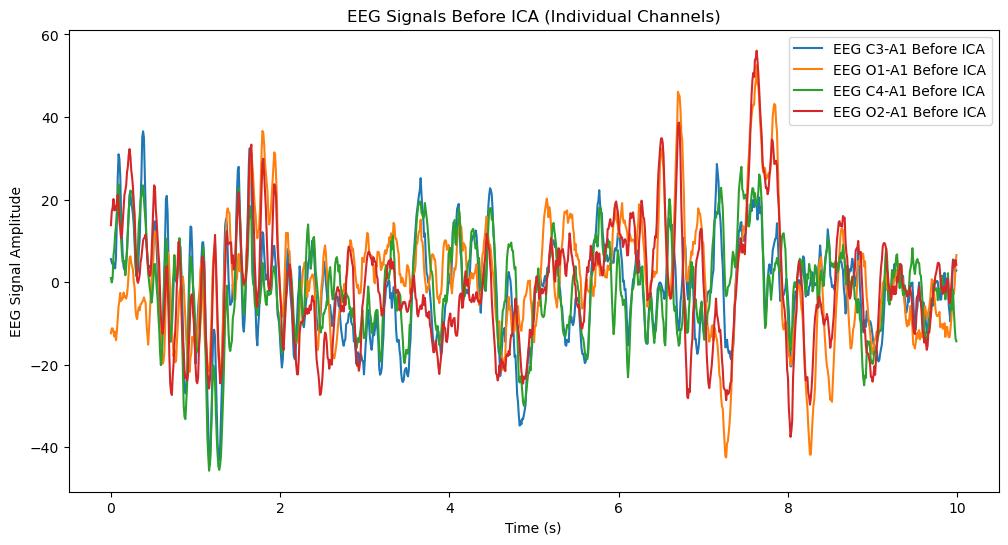

In [6]:
start_idx = int(start_time * raw.info['sfreq'])
end_idx = int(end_time * raw.info['sfreq'])


plt.figure(figsize=(12, 6))
for i, column in enumerate(eeg_columns):
    plt.plot(raw.times[start_idx:end_idx],
             raw.get_data()[i, start_idx:end_idx],
             label=f'{column} Before ICA')

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Amplitude')
plt.title('EEG Signals Before ICA (Individual Channels)')
plt.legend()
plt.show()

In [7]:

ica = mne.preprocessing.ICA(n_components=4, random_state=97, max_iter=800)

# High-pass filter at 1 Hz
raw.filter(l_freq=1.0, h_freq=None)


ica.fit(raw)
ica.exclude = [0,3]
raw_cleaned = raw.copy()
ica.apply(raw_cleaned)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 4 PCA components


<RawArray | 4 x 248440 (2484.4 s), ~7.6 MB, data loaded>

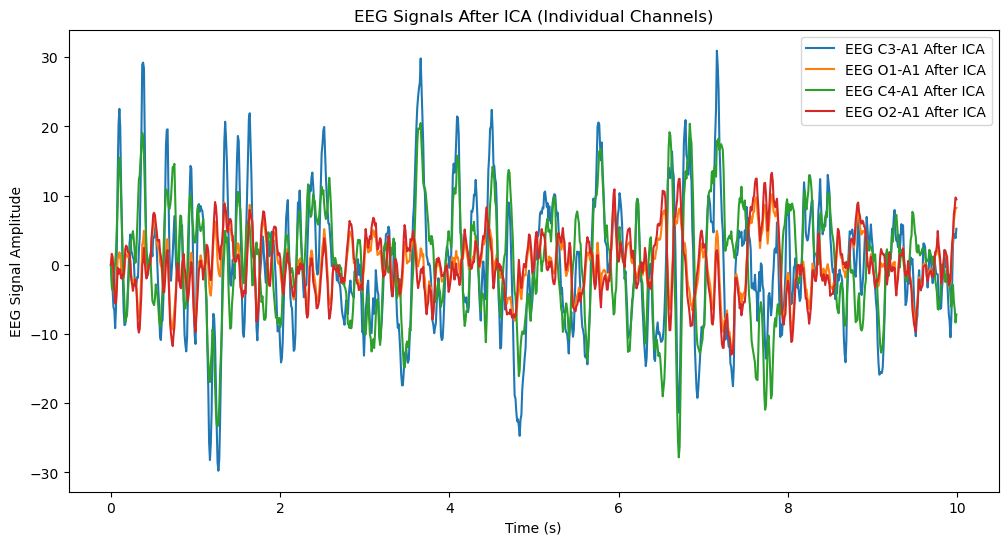

In [8]:

start_time = 0
end_time = 10  


start_idx = int(start_time * raw_cleaned.info['sfreq'])
end_idx = int(end_time * raw_cleaned.info['sfreq'])


eeg_data_cleaned = raw_cleaned.get_data()


plt.figure(figsize=(12, 6))
for i, column in enumerate(eeg_columns):
    plt.plot(raw_cleaned.times[start_idx:end_idx],
             eeg_data_cleaned[i, start_idx:end_idx],
             label=f'{column} After ICA')

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Amplitude')
plt.title('EEG Signals After ICA (Individual Channels)')
plt.legend()
plt.show()


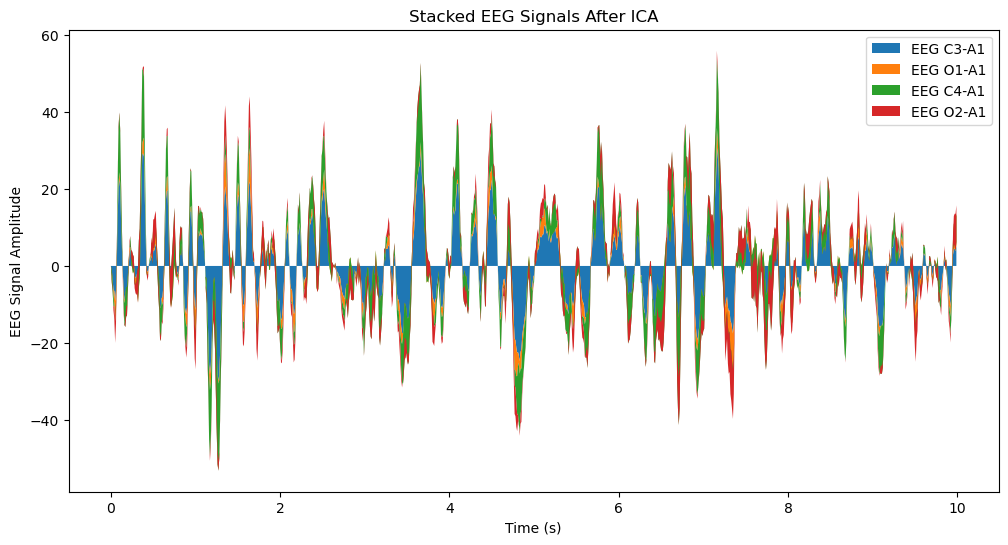

In [9]:
start_idx = int(start_time * raw_cleaned.info['sfreq'])
end_idx = int(end_time * raw_cleaned.info['sfreq'])


eeg_data_cleaned = raw_cleaned.get_data()


plt.figure(figsize=(12, 6))
plt.stackplot(raw_cleaned.times[start_idx:end_idx],
              eeg_data_cleaned[:, start_idx:end_idx],
              labels=eeg_columns)
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Amplitude')
plt.title('Stacked EEG Signals After ICA')
plt.legend()
plt.show()

In [10]:

epochs = mne.make_fixed_length_epochs(raw_cleaned, duration=2, preload=True)


freq_bands = {'delta': (0, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 20)}


features = {}
for band, (low, high) in freq_bands.items():
    # Band-pass filter
    epochs_band = epochs.copy().filter(l_freq=low, h_freq=high)

    # Mean power
    mean_power = epochs_band.get_data().var(axis=2).mean(axis=0)
    features[f'mean_power_{band}'] = mean_power

# Standard deviation of signal
std_dev = epochs.get_data().std(axis=2).mean(axis=0)
features['std_dev'] = std_dev

# Spectral entropy 
power_data = epochs.get_data() ** 2  
power_ratios = power_data / np.sum(power_data, axis=2, keepdims=True)
spectral_entropy = -np.sum(power_ratios * np.log2(power_ratios + 1e-12), axis=2)
features['spectral_entropy'] = spectral_entropy.mean(axis=0)


features_df = pd.DataFrame(features)
print(features_df.head())

Not setting metadata
1242 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1242 events and 200 original time points ...
0 bad epochs dropped
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done 4968 out of 4968 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done 4968 out of 4968 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 13 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 103 samples (1.030 sec)



[Parallel(n_jobs=1)]: Done 4968 out of 4968 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


   mean_power_delta  mean_power_theta  mean_power_alpha  mean_power_beta  \
0         83.235505         32.409188         12.125928         3.087066   
1         10.438489          4.907224          2.396941         0.683062   
2         64.908911         21.328066          7.429837         1.729074   
3         16.083973          6.753832          3.149142         0.869574   

     std_dev  spectral_entropy  
0  10.060602          6.616268  
1   3.700268          6.600413  
2   8.673436          6.616511  
3   4.507473          6.600773  


[Parallel(n_jobs=1)]: Done 4968 out of 4968 | elapsed:    0.2s finished


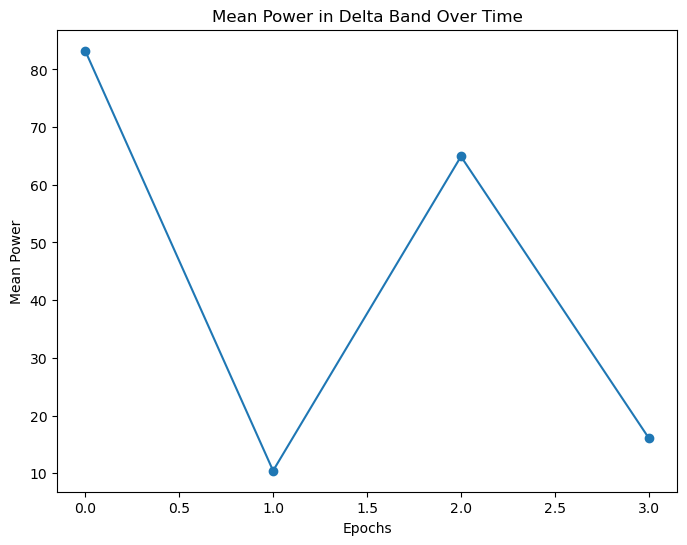

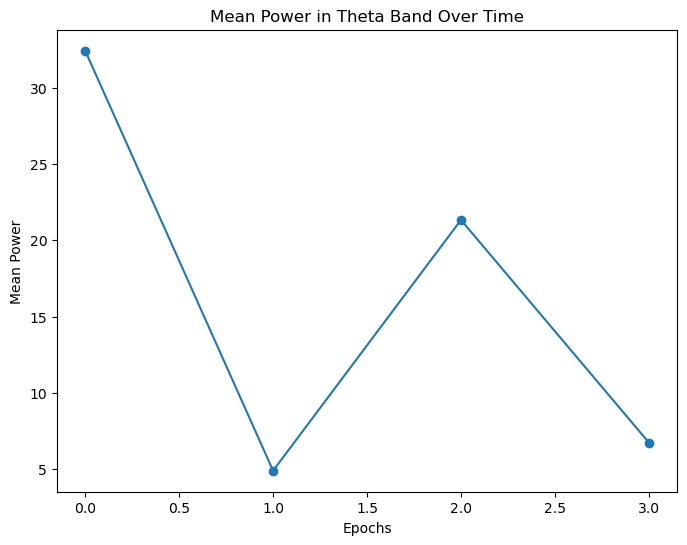

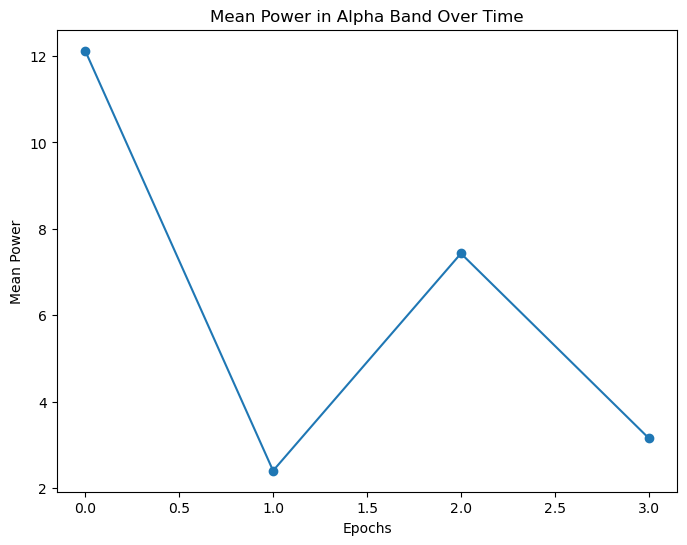

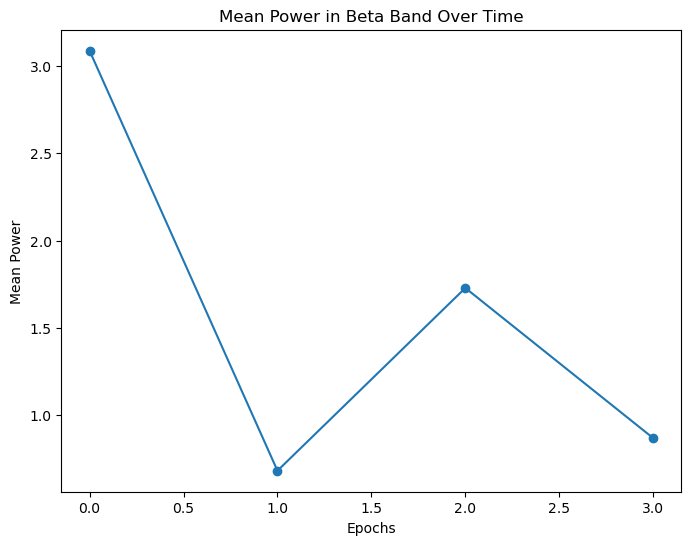

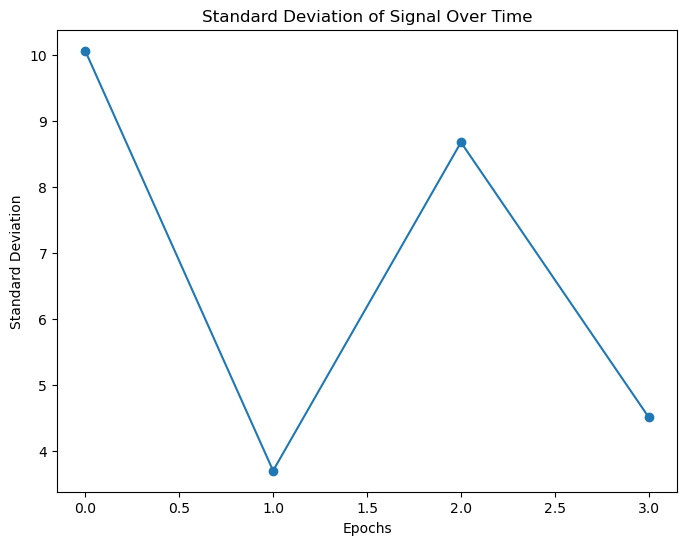

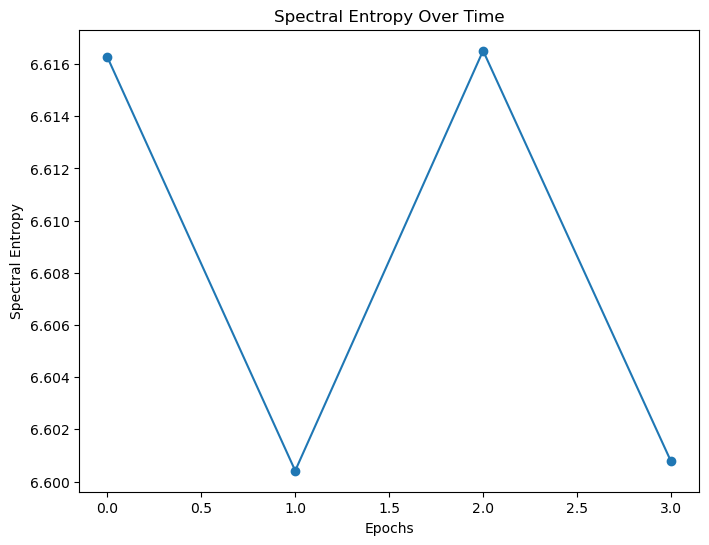

In [11]:


plt.figure(figsize=(8, 6))
plt.plot(features_df['mean_power_delta'], marker='o')
plt.title('Mean Power in Delta Band Over Time')
plt.xlabel('Epochs')
plt.ylabel('Mean Power')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(features_df['mean_power_theta'], marker='o')
plt.title('Mean Power in Theta Band Over Time')
plt.xlabel('Epochs')
plt.ylabel('Mean Power')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(features_df['mean_power_alpha'], marker='o')
plt.title('Mean Power in Alpha Band Over Time')
plt.xlabel('Epochs')
plt.ylabel('Mean Power')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(features_df['mean_power_beta'], marker='o')
plt.title('Mean Power in Beta Band Over Time')
plt.xlabel('Epochs')
plt.ylabel('Mean Power')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(features_df['std_dev'], marker='o')
plt.title('Standard Deviation of Signal Over Time')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(features_df['spectral_entropy'], marker='o')
plt.title('Spectral Entropy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Spectral Entropy')
plt.show()



Not setting metadata
1242 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1242 events and 200 original time points ...
0 bad epochs dropped
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done 4968 out of 4968 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 165 samples (1.650 sec)



[Parallel(n_jobs=1)]: Done 4968 out of 4968 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 13 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 103 samples (1.030 sec)



[Parallel(n_jobs=1)]: Done 4968 out of 4968 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4968 out of 4968 | elapsed:    0.2s finished


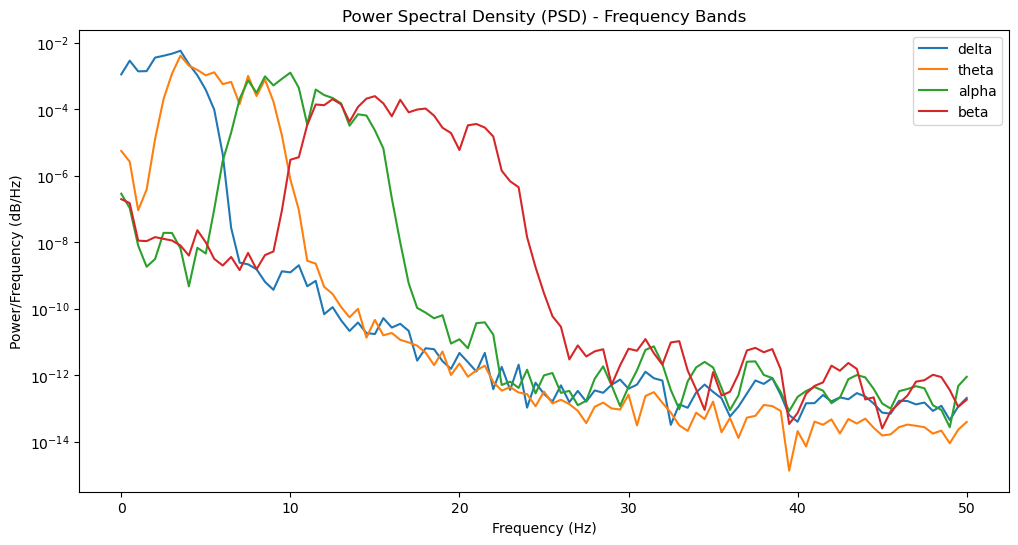

In [12]:

epochs = mne.make_fixed_length_epochs(raw_cleaned, duration=2, preload=True)
psd_freq_bands = {'delta': (0, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 20)}

#PSD for each frequency band
plt.figure(figsize=(12, 6))
for band, (low, high) in psd_freq_bands.items():
    # Band-pass filter
    epochs_band = epochs.copy().filter(l_freq=low, h_freq=high)

    #Extraction of cleaned EEG data for the specific band
    eeg_data_band = epochs_band.get_data().mean(axis=0) 

    #PSD using Welch method
    nperseg = min(256, len(eeg_data_band[0]))
    frequencies, psd = welch(eeg_data_band, fs=raw_cleaned.info['sfreq'], nperseg=nperseg)
    
    plt.semilogy(frequencies, psd.mean(axis=0), label=band)  
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density (PSD) - Frequency Bands')
plt.legend()
plt.show()

